<a href="https://colab.research.google.com/github/Osbird/MachineLearningForKnowledgeService_KnowledgeEngineering/blob/master/MachineLearningForKnowledgeService/%5Bhw2%5DFully%20connected%20NN%20%26%20Parameter%20Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KSE 801, Homework 02

References:
- https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

------------------------

In [0]:
%pylab inline
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import itertools

# device will be set as cpu if you do not have a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.__version__)

Populating the interactive namespace from numpy and matplotlib
1.0.1.post2


-----------------------

### [Task 1] Load your datasets and make your own dataloader

pytorch provides many tools to make data loading easy. In this homework, we will use MNIST datasets. 

To load the data, you have to set 'Dataset' class and 'DataLoader'. But since pytorch contains a module to load MNIST datasets, you can use it.



In [0]:
file_path = './data' # write your own path
batch_size = 64

train_dataset = datasets.MNIST(root=file_path, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=file_path, train=False, transform=transforms.ToTensor(), download=True)

dataset_sizes = {'train' : train_dataset.__len__(), 
                 'test' : test_dataset.__len__()} 

################################# [Task 1] ############################################
"Dataloader makes an iterable object which can make us load inputs and labels."

dataloaders = {'train' : DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
              'test' : DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4) }

#dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4) 

#######################################################################################

Confirm that you made correct dataloader

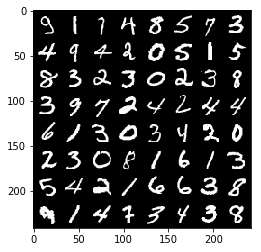

tensor([9, 1, 7, 4, 8, 5, 7, 3, 4, 9, 4, 2, 0, 5, 1, 5, 8, 3, 2, 3, 0, 2, 3, 8,
        3, 9, 7, 2, 4, 2, 4, 4, 6, 1, 3, 0, 3, 4, 2, 0, 2, 3, 0, 8, 1, 6, 1, 3,
        5, 4, 2, 1, 6, 6, 3, 8, 9, 1, 4, 7, 3, 4, 3, 8])


In [0]:
def imshow(img):
    'function to show your data sample'
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    
input_example, label_example = next(iter(dataloaders['train']))
#print(input_example.shape)
batch_grid = torchvision.utils.make_grid(input_example)

imshow(batch_grid)
print(label_example)

-----------------------

### [Task 2] Make a fully connected NN model

In this homework, we will use a tiny MLP(fully connected NN) model. In pytorch, you can make a model by

(1) inheriting 'nn.Module' class and (2) overriding '__ init__( )' and '__ forward__( )' method

(Note that _we do not use convolutional layer_ in this homework)

#### Our Homework_Net should have following structure:
    - [layer1] : fully connected layer with input size 784, hidden size (H1)
    
    (activation function)
    
    - [layer2] : fully connected layer with hidden size (H1), hidden size (H2)
    
    (activation function)
    
    ......
    
    - [final layer] : fully connected layer with (HF), output size 10 (num of classes)
    
    



In [0]:
class HomeworkNetLinear(nn.Module):
    
################################# [Task 2] ############################################
    "fc3 doesn't mean you can use up to 3 layers. you can add more lines if you want"    
    def __init__(self):
        super(HomeworkNetLinear, self).__init__()
        self.fc1 = nn.Linear(28**2, 18**2,1)
        self.fc2 = nn.Linear(18**2, 11**2,1)
        self.fc3 = nn.Linear(11**2, 6**2,1)
        self.fc4 = nn.Linear(6**2, 10,1)
        
    def forward(self, x):
        x = x.view(-1, 28*28) # make inputs flat
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x
    
######################################################################################

class HomeworkNetNonLinear(nn.Module):
    
    def __init__(self, activation):
        super(HomeworkNetNonLinear, self).__init__()
        self.fc1 = nn.Linear(28**2, 18**2,1)
        self.fc2 = nn.Linear(18**2, 11**2,1)
        self.fc3 = nn.Linear(11**2, 6**2,1)
        self.fc4 = nn.Linear(6**2, 10,1)
        self.activation = activation
        
    def forward(self, x):
        x = x.view(-1, 28*28) # make inputs flat
        x = self.activation(self.fc1(x)) # fun to see the tensor size: print(x.size())
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        return x

Confirm that your 'Homework_Net' works

In [0]:
test_net = HomeworkNetNonLinear(F.relu)
test_tensor = torch.randn(64, 1, 28, 28)
output = test_net(test_tensor) # error will be rasied if your Net doesn't work

print(output.shape) # tensor size with ([batch_size, 10]) is expected

torch.Size([64, 10])


-----------------------

### [Task 3] Train your model

Finally you can train your own model. Complete train_model function and compare models with various settings to answer HW problems.

We wrote settings & hyperparameters suggestion below but it doesn't mean you have to try all the settings.

The __train_model__ function returns trained model, train&test loss and accuracy, and loss per batch.

In [0]:
# activation = [F.relu, F.tanh, F.sigmoid, F.leaky_relu, F.relu6]
# criterion = [nn.CrossEntropyLoss, nn.MSELoss, nn.L1Loss, nn.NLLLoss, nn.KLDivLoss]
# optimizer = [optim.SGD, optim.Adagrad, optim.Adam, optim.RMSprop] #optim.SGD(test_net.parameters(), lr=0.001, momentum=0.9) 
# lr = [0.1, 0.01, 0.001]
# batch_size = [8, 16, 64, 128, 256, 60000]

In [0]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs, device):
    
    model = model.to(device)
    model.train() # set train mode
    
    # list of loss and accuracy. you will need this to plot training results
    train_loss, train_acc = [], []
    
    # list of loss per batch. Compare the convergence rate difference using this.
    train_loss_batch = []
    
    # for each epoch
    print('Epoch: ', end = '')
    for epoch in range(num_epochs):
        print('- {}/{} '.format(epoch+1, num_epochs), end='')
        
        running_loss, running_corrects = 0.0, 0
        
        # for each batch
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
    ################################# [Task 3-1] ############################################ 
    
            # make sure all the gradients of parameter tensors are zero
            optimizer.zero_grad()

            
            # get the model output
            outputs = model(inputs)
            
            # get the prediction of model (hint: use torch.max function to outputs)
            _, preds = torch.max(outputs, 1)
            
            # calculate loss of the output (hint: loss is calculated between outputs and labels)
            loss = criterion(outputs, labels)
            
            # backpropagation
            loss.backward()
            
            # update model parameters using optimzier
            optimizer.step()
            
    ########################################################################################

            batch_loss_total = loss.item() * inputs.size(0) # total loss of the batch
            running_loss += batch_loss_total # cumluative sum of loss
            running_corrects += torch.sum(preds == labels.data) # cumulative sum of correct count
            
            batch_loss = batch_loss_total/dataloaders['train'].batch_size
            train_loss_batch.append(batch_loss)

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        #print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        #print('-' * 10)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
    
    # after tranining epochs, test epoch starts
    else:
        model.eval() # set test mode
        running_loss, running_corrects = 0.0, 0
        
        # for each batch
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
    ################################# [Task 3-2] ############################################
    
    
            # same with the training part.
            # but you don't have to backprop and updating pramas here.
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            
            
     ########################################################################################
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        test_loss = running_loss / dataset_sizes['test']
        test_acc = (running_corrects.double() / dataset_sizes['test']).item()
        print('\n<Test Loss: {:.4f} Acc: {:.4f}>'.format(test_loss, test_acc))
        
    return model, train_loss, train_acc, test_loss, test_acc, train_loss_batch

# Problem 1
### Test all combinations of hyperparams to find the best params
**The dataset is comparably small enough to test the cartesian product of combinations**
 

In [0]:
activation = [F.relu, F.tanh, F.sigmoid, F.leaky_relu, F.relu6]
criterion = [nn.CrossEntropyLoss, nn.NLLLoss]
optimizer = [optim.SGD, optim.Adagrad, optim.Adam, optim.RMSprop] 
lr = [0.1, 0.01, 0.001]
batch_size = [8, 16, 64, 128, 256, 60000]

num_epochs = 6

def setOptimizerParameters(optimizerParamTuple):
    return optimizerParamTuple[0](optimizerParamTuple[2].parameters(), lr=optimizerParamTuple[1])


  
def runAllHyperParamCombinations(criterion,optimizer,lr, activation, batch_size):
  #iterating over the cartesian product of combinations, without duplicates
  combinationList = set(itertools.product(*[criterion,optimizer,lr, activation, batch_size]))
  n = 0
  for combination in combinationList:
      #Set the iterations hyperparams & instantiate new nets
      linearModel = HomeworkNetLinear().to(device)
      nonLinearModel = HomeworkNetNonLinear(combination[3]).to(device)
      batch_size = combination[4]
      linearParameters = [combination[0](),setOptimizerParameters((combination[1],combination[2],linearModel))]
      nonLinearParameters = [combination[0](),setOptimizerParameters((combination[1],combination[2],nonLinearModel))]
      dataloaders = {'train' : DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                     'test' : DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0) }

      #Print params and scores to console
      print('Iteration: \t{}\n    Loss function: \t{}\n    Learning rate: \t{}\n    Optmizer: \t{}\n    Batch size: \t{}\n    Activation func: \t{}'.format(n,combination[0].__name__, combination[2], combination[1].__name__, combination[4], combination[3].__name__).expandtabs(22))
      print('\nlinear model:')
      trained_model_lin, train_loss_lin, train_acc_lin, test_loss_lin, test_acc_lin, train_loss_batch_lin = train_model(linearModel, dataloaders, dataset_sizes,
                                                                                                *linearParameters, num_epochs, device)
      print('non-linear model:')
      trained_model_nonlin, train_loss_nonlin, train_acc_nonlin, test_loss_nonlin, test_acc_nonlin, train_loss_batch_nonlin = train_model(nonLinearModel, dataloaders, dataset_sizes,
                                                                                                *nonLinearParameters, num_epochs, device)
      # Plot loss graphs, without nan values
      lin_without_nan=list(filter(None.__ne__, train_loss_lin))
      nonlin_without_nan=list(filter(None.__ne__, train_loss_nonlin))
      plt.plot( range(0,len(lin_without_nan)), lin_without_nan, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label='linear({:0.4f})'.format(test_acc_lin), alpha=0.5)
      plt.plot( range(0,len(nonlin_without_nan)), nonlin_without_nan, marker='', color='olive', linewidth=2, label='non-linear({:0.4f})'.format(test_acc_nonlin), alpha=0.5)
      plt.legend(loc='upper left')
      plt.show()
      
      n+=1
  

#runAllHyperParamCombinations(criterion,optimizer,lr, activation, batch_size)

-----------------
### Initializing with same weights

To solve 'Problem2' in 'Homework2', the initial parameters of the networks should be same. By initializing a network and saving it, you can make initial weights of new networks same.

You may get the same result by setting manual seed, but note that the way that setting manual seed for cpu and gpu is different.
(torch.manual_seed) and (torch.cuda.manual_seed_al) 

https://pytorch.org/docs/master/cuda.html#random-number-generator

In [0]:
# Make an initialized network
initialized_net = HomeworkNetNonLinear(F.relu)

# save it with dictionary file
torch.save(initialized_net.state_dict(), './initialized_net.pth')

# make new network and load initial weights
new_net = HomeworkNetNonLinear(F.relu)
new_net.load_state_dict(torch.load('./initialized_net.pth'))

-----------------
### Train models using different optimizers

You have to train your model multiple times to compare convergence rate between different optimizers.

Get train_loss_batch and test accuracy to plot the data. The scratch of code is provided below.

In [0]:
acti = F.relu
model1 = HomeworkNetNonLinear(acti).to(device)
model1.load_state_dict(torch.load('./initialized_net.pth')) # initalized weights
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())
num_epochs= 20
batch_size_setting= 64
dataloaders = {'train' : DataLoader(train_dataset, batch_size=batch_size_setting, shuffle=True, num_workers=0),
                     'test' : DataLoader(test_dataset, batch_size=batch_size_setting, shuffle=True, num_workers=0) }


_, _, _, _, test_acc1, train_loss_batch1 = train_model(model1, dataloaders, dataset_sizes, 
                                                      criterion, optimizer, num_epochs, device)

model2 = HomeworkNetNonLinear(acti).to(device)
model2.load_state_dict(torch.load('./initialized_net.pth')) # initalized weights
optimizer = optim.Adagrad(model2.parameters())



_, _, _, _, test_acc2, train_loss_batch2 = train_model(model2, dataloaders, dataset_sizes, 
                                                      criterion, optimizer, num_epochs, device)

model3 = HomeworkNetNonLinear(acti).to(device)
model3.load_state_dict(torch.load('./initialized_net.pth')) # initalized weights
optimizer = optim.SGD(model3.parameters(), lr=0.01)


_, _, _, _, test_acc3, train_loss_batch3 = train_model(model3, dataloaders, dataset_sizes, 
                                                      criterion, optimizer, num_epochs, device)

model4 = HomeworkNetNonLinear(acti).to(device)
model4.load_state_dict(torch.load('./initialized_net.pth')) # initalized weights
optimizer = optim.RMSprop(model4.parameters())


_, _, _, _, test_acc4, train_loss_batch4 = train_model(model4, dataloaders, dataset_sizes, 
                                                      criterion, optimizer, num_epochs, device)


Epoch: - 1/20 - 2/20 - 3/20 - 4/20 - 5/20 - 6/20 - 7/20 - 8/20 - 9/20 - 10/20 - 11/20 - 12/20 - 13/20 - 14/20 - 15/20 - 16/20 - 17/20 - 18/20 - 19/20 - 20/20 
<Test Loss: 0.5760 Acc: 0.7712>
Epoch: - 1/20 - 2/20 - 3/20 - 4/20 - 5/20 - 6/20 - 7/20 - 8/20 - 9/20 - 10/20 - 11/20 - 12/20 - 13/20 - 14/20 - 15/20 - 16/20 - 17/20 - 18/20 - 19/20 - 20/20 
<Test Loss: 0.7820 Acc: 0.6752>
Epoch: - 1/20 - 2/20 - 3/20 - 4/20 - 5/20 - 6/20 - 7/20 - 8/20 - 9/20 - 10/20 - 11/20 - 12/20 - 13/20 - 14/20 - 15/20 - 16/20 - 17/20 - 18/20 - 19/20 - 20/20 
<Test Loss: 0.5573 Acc: 0.7829>
Epoch: - 1/20 - 2/20 - 3/20 - 4/20 - 5/20 - 6/20 - 7/20 - 8/20 - 9/20 - 10/20 - 11/20 - 12/20 - 13/20 - 14/20 - 15/20 - 16/20 - 17/20 - 18/20 - 19/20 - 20/20 
<Test Loss: 2.1032 Acc: 0.1899>


--------------------

### batchloss_smoother

To plot the convergence rate, use loss per batch instead of loss per epoch. It will show the difference more clearly. 

Though, the variance of loss per batch is too large to plot. Use __batchloss_smoother__ .

In [0]:
def batchloss_smoother(train_loss_batch):
    loss_batch = np.array(train_loss_batch)
    loss_batch_avg = []
    for i in range(loss_batch.size//10-1):
        avg_loss = loss_batch[0+(10*i):9+(10*i)].mean()
        loss_batch_avg.append(avg_loss)
    return loss_batch_avg

#### example of usage

In [0]:
adam_loss = batchloss_smoother(train_loss_batch1)
adagrad_loss = batchloss_smoother(train_loss_batch2) 
sgd_loss = batchloss_smoother(train_loss_batch3)
rmsprop_loss = batchloss_smoother(train_loss_batch4)

--------------------

### Plot the training

To help your plotting, simple plotting code is provided below. You can use this if you're not familiar with plotting codes

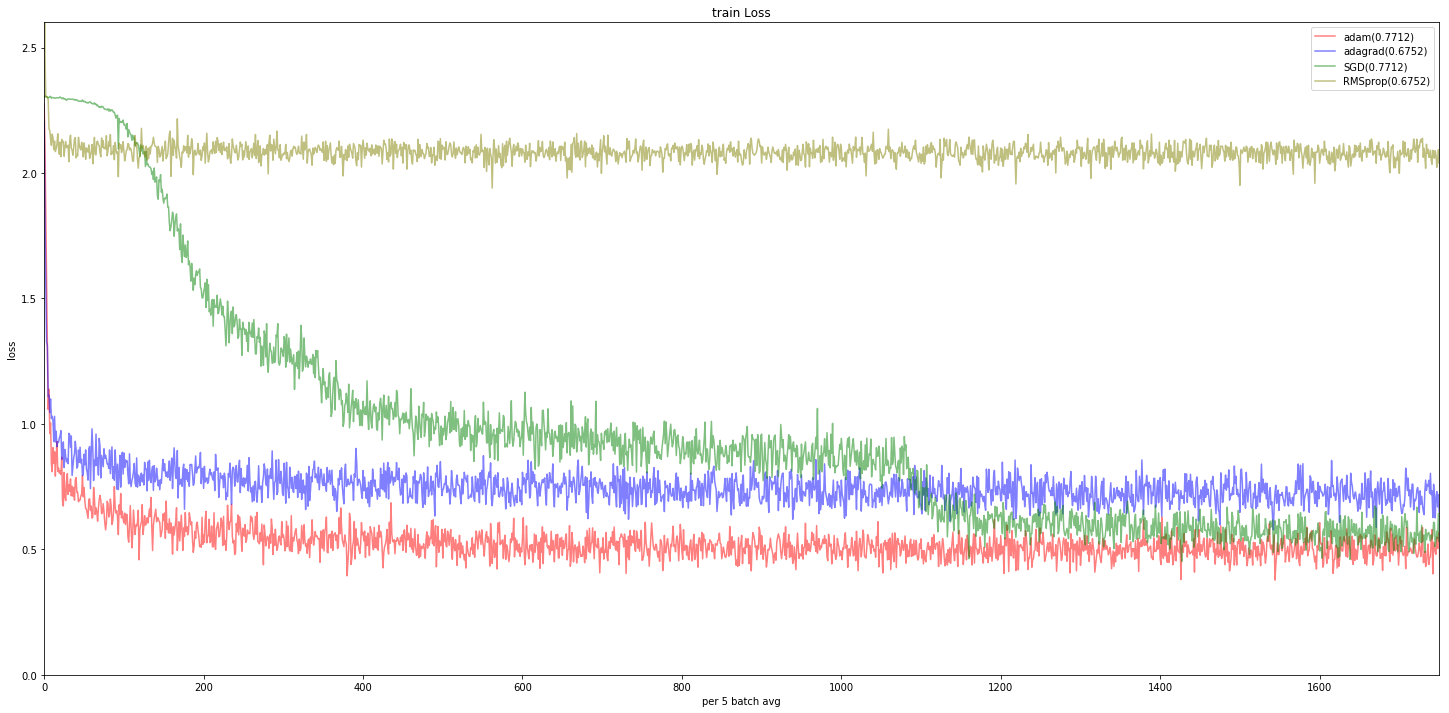

In [0]:
plt.figure(figsize=(25,12))
plt.plot(adam_loss, 'r', linestyle='-', label='adam({:0.4f})'.format(test_acc1), alpha=0.5)
plt.plot(adagrad_loss, 'b', linestyle='-', label='adagrad({:0.4f})'.format(test_acc2), alpha=0.5)
plt.plot(sgd_loss, 'g', linestyle='-', label='SGD({:0.4f})'.format(test_acc1), alpha=0.5)
plt.plot(rmsprop_loss, 'olive', linestyle='-', label='RMSprop({:0.4f})'.format(test_acc2), alpha=0.5)
plt.title('train Loss')
plt.xlabel('per 5 batch avg')
plt.ylabel("loss")
plt.ylim(0,2.6)
plt.xlim(0,250*7)
plt.legend()
plt.show()